In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


#Carregando a base que salva 
df_vendas = pd.read_csv('base_completa_limpa.csv')

#Carregando o dataset de reviews da Olist
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')

# Merge Interno (Inner)
#filtrando apenas as vendas que possuem comentário, 
# evitando que a memória processe linhas vazias.

df_vendas_filtro = df_vendas.copy()

df_sentimento = pd.merge(
    df_vendas,
    df_reviews[['order_id', 'review_comment_message', 'review_score']], 
    on='order_id', 
    how='inner'
)

# 4. Remover linhas sem comentário de texto
df_sentimento = df_sentimento.dropna(subset=['review_comment_message'])

print(f"Total de comentários para analisar: {len(df_sentimento)}")


Total de comentários para analisar: 47642


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicollas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 800x600 with 0 Axes>

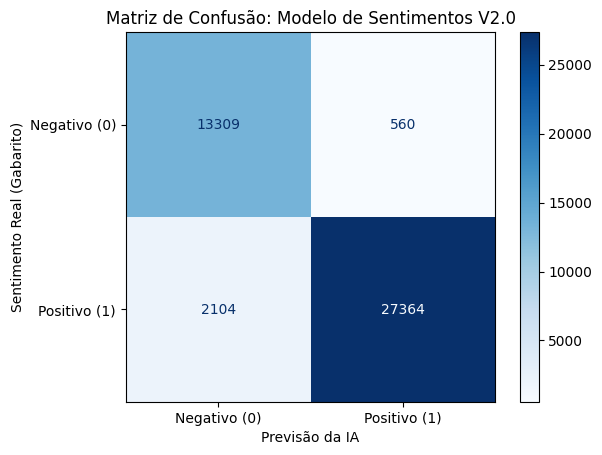

Acurácia atualizada: 93.85%


<Figure size 640x480 with 0 Axes>

In [19]:
sem_3 = df_sentimento[df_sentimento['review_score'] != 3].copy()

sem_3['target'] = sem_3['review_score'].apply(lambda x : 1 if x > 3 else 0)

nltk.download('stopwords')
stops = stopwords.words('portuguese')

# Configurando o Vetorizador de Alta Performance
# ngram_range=(1, 2) faz o modelo entender que "não" + "bom" = ruim
vetorizador = TfidfVectorizer(
    max_features=10000,      # Aumentamos o vocabulário
    ngram_range=(1, 2),      # Analisa palavras sozinhas e pares de palavras
    stop_words=stops         # Remove "de", "a", "o", "eu", etc.
)

#Re-treinar

X_vetorizado = vetorizador.fit_transform(df_sentimento['review_comment_message'])

# 1. Aplicando o novo vetorizador (com stopwords e n-grams)

X = vetorizador.fit_transform(sem_3['review_comment_message'])
y = sem_3['target']




# Treinando o modelo 

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X, y)

# Gerar as previsões do modelo para a base de teste 
y_pred = model.predict(X)

# Criar a matriz
cm = confusion_matrix(y, y_pred)

#Plotar de forma visual e profissional
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativo (0)', 'Positivo (1)'])
disp.plot(cmap='Blues', values_format='d')

plt.title('Matriz de Confusão: Modelo de Sentimentos V2.0')
plt.xlabel('Previsão da IA')
plt.ylabel('Sentimento Real (Gabarito)')
plt.show()


plt.savefig('matriz_confusao.png', dpi=300, bbox_inches='tight')

print(f"Acurácia atualizada: {model.score(X, y):.2%}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
print(f"Acurácia: {model.score(X_test, y_test):.2%}")


frase = ["O produto chegou muito rápido e é de ótima qualidade"]
frase_vetorizada = vetorizador.transform(frase)
predicao = model.predict(frase_vetorizada)
print(f"Predição (1=Bom, 0=Ruim): {predicao[0]}")

Acurácia: 93.74%
Predição (1=Bom, 0=Ruim): 1


In [15]:
frase_ruim = ["O produto é péssimo, veio quebrado e o suporte não me ajudou."]
frase_ruim_vetorizada = vetorizador.transform(frase_ruim)
predicao_ruim = model.predict(frase_ruim_vetorizada)

print(f"Predição para crítica (0=Ruim): {predicao_ruim[0]}")

Predição para crítica (0=Ruim): 0


In [16]:
# Pegar os nomes das palavras que o TfidfVectorizer criou
palavras = vetorizador.get_feature_names_out()

#  Pegar os coeficientes (pesos) que o modelo atribuiu a cada palavra
pesos = model.coef_[0]

# Criar um DataFrame para facilitar a ordenação e leitura
df_pesos = pd.DataFrame({
    'palavra': palavras,
    'peso': pesos
})

# Mostrar as 10 que mais puxam para o "Bom" (1)
print("--- TOP 10 PALAVRAS POSITIVAS ---")
print(df_pesos.sort_values(by='peso', ascending=False).head(10))

print("\n" + "="*30 + "\n")

# Mostrar as 10 que mais puxam para o "Ruim" (0)
print("--- TOP 10 PALAVRAS NEGATIVAS ---")
print(df_pesos.sort_values(by='peso', ascending=True).head(10))

--- TOP 10 PALAVRAS POSITIVAS ---
        palavra      peso
738       antes  6.196738
4037  excelente  5.963100
8499     rápido  5.821630
9956      ótimo  5.787064
9425       tudo  5.342068
6286   parabéns  5.125545
387      adorei  5.009912
5250      lindo  4.947633
674        amei  4.856275
8471     rápida  4.808752


--- TOP 10 PALAVRAS NEGATIVAS ---
       palavra      peso
2163   comprei -5.083996
7720   péssimo -4.485858
8008    recebi -4.430537
7715   péssima -4.272844
5804       nao -3.881158
4162  faltando -3.833243
8466      ruim -3.716776
2493   contato -3.584034
8379  resposta -3.571915
4931  inferior -3.545360


In [17]:
import joblib

# Salva o modelo (o cérebro)
joblib.dump(model, 'modelo_sentimento.pkl')

#  Salva o vetorizador (o dicionário que traduz palavras em números)
joblib.dump(vetorizador, 'vetorizador.pkl')

print("Arquivos salvos com sucesso!")

Arquivos salvos com sucesso!


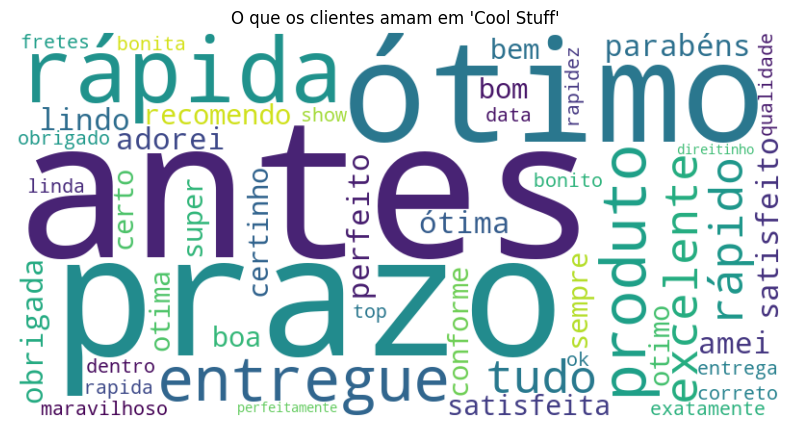

In [18]:
# Criando uma lista de palavras para ignorar (Stopwords)
ignorar = ['não', 'nao', 'que', 'se', 'um', 'uma', 'com', 'os', 'as', 'já', 'até', 'dois', 'meu', 'pelo']

# Filtrando o dataFrame de pesos para pegar apenas o que é relevante

positivas = df_pesos.sort_values(by='peso', ascending=False).head(50)
texto_nuvem = " ".join(positivas[~positivas['palavra'].isin(ignorar)]['palavra'])

# Gerando a nuvem
nuvem = WordCloud(width=800, height=400, background_color='white').generate(texto_nuvem)

# Exibindo o gráfico
plt.figure(figsize=(10, 5))
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.title("O que os clientes amam em 'Cool Stuff'")
plt.show()

In [92]:
features = vetorizador.get_feature_names_out()
pesos = model.coef_[0]

# Criando um DataFrame para comparar
df_pesos = pd.DataFrame({'termo': features, 'peso': pesos})

# Filtrando apenas termos com duas palavras (Bigramas) e vendo os mais negativos
bigramas_negativos = df_pesos[df_pesos['termo'].str.contains(' ')].sort_values(by='peso').head(10)

print("--- TOP 10 BIGRAMAS NEGATIVOS (O que a IA mais detesta) ---")
print(bigramas_negativos)

--- TOP 10 BIGRAMAS NEGATIVOS (O que a IA mais detesta) ---
                  termo      peso
8022      recebi apenas -2.698672
544      ainda entregue -2.449813
7012        prazo porém -2.297306
7719  péssima qualidade -2.263305
1236          boa tarde -2.200862
1107    baixa qualidade -1.922164
536        ainda chegou -1.908546
7784     qualidade ruim -1.858827
2726      cumpriu prazo -1.850608
7092      presente data -1.770217
